# Lab3. Amazon SageMaker DeepAR

This notebook shows how to apply the SageMaker [DeepAR built-in algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN) to produce both point and probabilistic forecasts.The DeepAR forecasting algorithm can provide better forecast accuracies compared to classical forecasting techniques such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ES), both of which are implemented in many open-source and commercial software packages for forecasting. 

## Table Of Contents
The overall process for this is:

1. Data Preparation
1. Training the DeepAR Model
1. Deploy and Prediction
1. Plotting the Prediction
1. Stop and Delete the Endpoint

To get started, simply execute the cells below:

## 1. Data Preparation

Let's look at the dataset first. We will use fake dataset that fascimile real clickstream data in data folder. 


In [123]:
# This notebook code was tested with SageMaker SDK 2.20
# !pip install -U sagemaker==2.20

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from util import *

Unzip the compressed file and look at the dataset.

In [125]:
data_dir='data'
!tar -zxvf $data_dir/data.tar.gz --directory=data

gzip: data/*.gz: No such file or directory


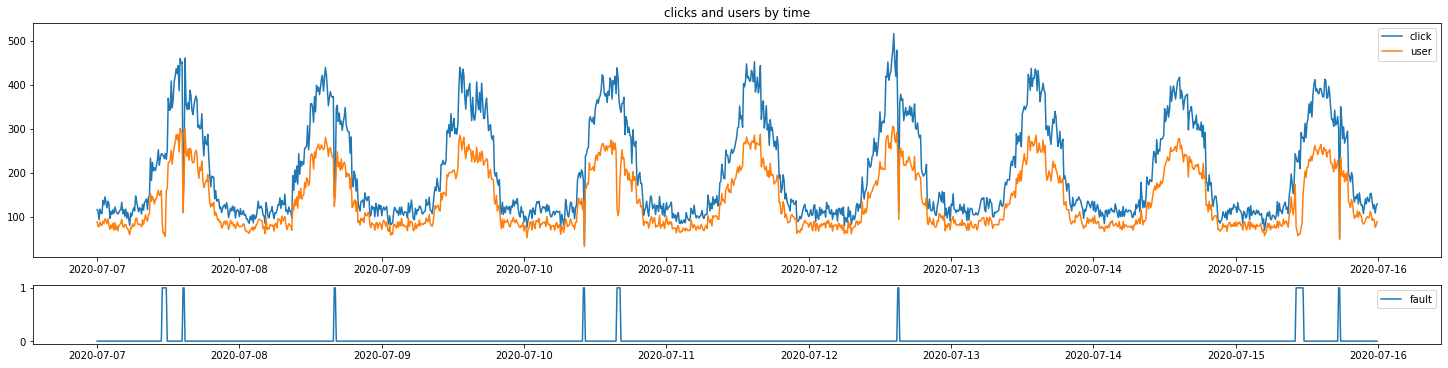

In [126]:
clicks_10T = pd.read_csv(data_dir + '/clicks_10T.csv', parse_dates=['timestamp']).set_index('timestamp')
clicks_10T['fault'] = pd.read_csv(data_dir + '/fault_label_10T.csv', header=None).values[0]

plot_click_w_fault(clicks_10T)

### Changing training data format for DeepAR

We only use click events to detect abnormal drops. (We will predict the number of clicks in 10 minutes and use the number of clicks as the target feature. We use data up to Jul 14th as our training dataset. Remaining 144 data points of Jul 15th will be used for testing the results.)

Change the data to the format that DeepAR algorithm use. The records in your input files should contain the following fields:

* **start** : The start timestamp. A string with the format YYYY-MM-DD HH:MM:SS.
* **target** : An array of floating-point values or integers that represent the time series. Here, we will use clickstream counts in 10 minutes for forecasting value. 
* **dynamic_feat (optional)** : An array of arrays of floating-point values or integers that represents the vector of custom feature time series. Here, we do not use dynamic_feat in this example but you may add hours (0,1,2,...23) or the number of users (assumming that we know the number of users at the timing of forecasting the number of clicks)
* **cat (optional)** : An array of categorical features that can be used to encode the groups that the record belongs to. We do not use categorical values in this example.

```python
# example:
{"start": "2020-07-01 00:00:00", "target": [24.0, 22.0, 20.0, 17.0, ...], "dynamic_feat": [[13, 14, 8, ...]]}
```

For more information, refer to input/outpot format of DeepAR : https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput


In [127]:
test = {'start': str(clicks_10T.index[0]),
         'target': list(clicks_10T['click']),
       }
train = {'start': str(clicks_10T.index[0]),
         'target': list(clicks_10T['click'])[:-144],
        }

Convert the dict type above into a json file.  
Then, write the training file in JSON Lines and upload it to S3.

In [128]:
import json
def write_dicts_to_file(path, training_data):
    with open(path, 'wb') as fp:
        for row in training_data:
            fp.write(json.dumps(row).encode("utf-8"))
            fp.write("\n".encode('utf-8'))
            
write_dicts_to_file("train.json", [train])

import sagemaker
import s3fs
import datetime

sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-clickstream'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker
train_s3 = sagemaker_session.upload_data(path='train.json', key_prefix=s3_prefix)

s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(train_s3, 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2020-07-07 00:00:00", "target": [116, 112, 93, 117, 108, 107, 137, 127, 145, 133, 120, 13...


## 2. Training the DeepAR Model

Just like other built-in algorithms, we need to define Estimator with algorhtim and hyperparameters and fit the model with the training data that we prepared above.

We are using the [Python SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/index.html) to:

1. Create our [Estimator](https://sagemaker.readthedocs.io/en/stable/estimators.html) defining the algorithm and fitting/hyper-parameters
2. Define our [data channels](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo-running-container.html#your-algorithms-training-algo-running-container-inputdataconfig) to fit and validate on
3. [Fit](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator.fit) a model to the data

Then, we need to set some hyperparameters. Some of them are related to the algorithm and some others are related to the training job. 
- `time_freq` : The granularity of the time series in the dataset. (M, W, D, H, min, ...)
- `context_length` : The number of time-points that the model gets to see before making the prediction. 
- `prediction_length` : The number of time-steps that the model is trained to predict (forecast horizon)
- `num_dynamic_feat` : The number of dynamic_feat provided in the data (default:`auto`) 
- `epochs` : The maximum number of passes over the training data
- `early_stopping_patience` : Training stops when no progress is made within the specified number of `epochs`.
- `mini_batch_size` : The size of mini-batches used during training
- `learning_rate` : The learning rate used in training

For more information, refer to the [DeepAR document](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html)

In [129]:
region = sagemaker_session.boto_region_name
image_name = sagemaker.image_uris.retrieve("forecasting-deepar",region)

# we use 10 minutes frequency for the time series
freq = datetime.timedelta(minutes=10)

# we predict for 24 hours (144 points) and use same context length with prediction length.
prediction_length = 24 * 6
context_length = 24 * 6 

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_name,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    base_job_name='deepar-clickstream'
)
hyperparameters = {
    "time_freq": '10min',
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_dynamic_feat" : "auto",
    "num_layers" : "1",
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "32",
    "learning_rate": "5E-4"
}
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model. Training will take about 10~20 minutes in c4.2xlarge instance.

In [ ]:
%%time
data_channels = {
    "train": train_s3
}

estimator.fit(data_channels, wait=True)
# sagemaker_session.logs_for_job(estimator.latest_training_job.name, wait=True)

## 3. Deploy and Prediction


Deploy the model with below code. 

In [131]:
from sagemaker.serializers import IdentitySerializer

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge', 
    serializer=IdentitySerializer(content_type="application/json"),
    wait=True)

---------------!

Inference of DeepAR reuqires data in a format similar to training.  
For more information, refer to inference format of DeepAR : https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html   
example format:
```
{  "instances": [{ "start": "2020-07-01 00:00:00",
            "target": [4.0, 10.0, "NaN", 100.0, 113.0],
            "cat": [0, 1],
            "dynamic_feat": [[1.0, 1.1, 2.1, 0.5, 3.1, 4.1, 1.2, 5.0, ...]]
        },... ],
    "configuration": { "num_samples": 50,
         "output_types": ["mean", "quantiles", "samples"],
         "quantiles": ["0.5", "0.9"]
    }}
```

Prepare test data with below code.  
We will predict last 144 timepoints to see the expected pattern of our clickstream. We do not use `dynamic_feat` but please note that you need to pass full length of timeseries (including 144 timepoints) if you use this feature.

In [132]:
%%time
inf_data = {"instances":[test],
            "configuration": {"num_samples": 100, 
                              "output_types": ["quantiles", "samples"], 
                              "quantiles": ["0.01", "0.5", "0.99"]}
           }
prediction = predictor.predict(json.dumps(inf_data).encode('utf-8'))

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 505 ms


## 4. Plotting the Prediction

Now we can visualize the prediction result and find anomalous points. To check the result, we will look at the data after JUL 15, 2020 00:00, and compare the results with the original clickstrem. 

DeepAR returns quantile predictions by given quantile values. We can use this scope as our anomaly boundary. For points above or below the upper or lower prediction boundaries, we can consider them to be anomaly.

2nd chart below is the result of resampling the prediction results by 30 minutes. You can aggregate values to smooth out the noisy result. Depending on the business case, the forecasting unit may be different from the one used in the training. If you resample them with larger units of time, the prediction results will be smoother. This kind of manipulation can be used to prevent too much frequent noise alarms when setting the upper/lower monitoring limit with the prediction range of time series.


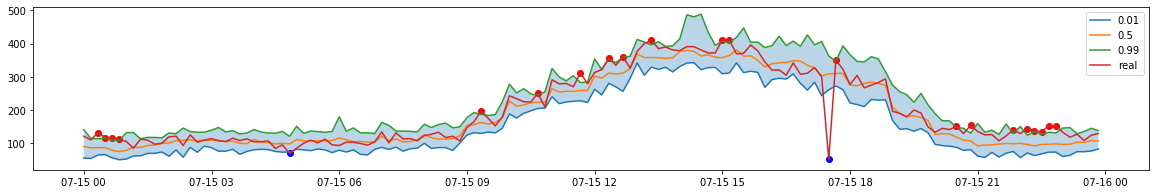

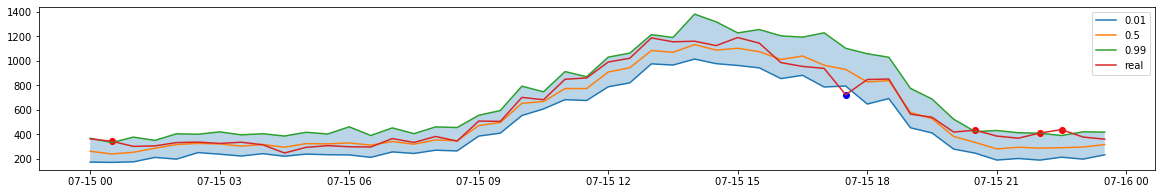

In [141]:
def plot_forecast(pred_ts1, real_ts, col=['0.1','0.5','0.9']):
    plt.figure(figsize=(20,3))
    plt.plot(pred_ts1)
    plt.plot(real_ts)
    
    u_idx = real_ts.values-pred_ts1['0.99'].values > 0
    b_idx = real_ts.values-pred_ts1['0.01'].values < 0
    anomalies_u = real_ts[u_idx]
    anomalies_b = real_ts[b_idx]
    
    plt.fill_between(pred_ts1.index, pred_ts1[col[-1]],pred_ts1[col[0]], alpha=0.3)
    plt.scatter(anomalies_u.index, anomalies_u.values, color='red')
    plt.scatter(anomalies_b.index, anomalies_b.values, color='blue')
    
    plt.legend(['0.01','0.5','0.99','real'])
    plt.show()

freq_r ='30T'
plot_forecast(pred_ts, clicks_10T['click'][-144:], col=['0.01','0.5','0.99'])
plot_forecast(pred_ts.resample(freq_r).sum(), clicks_10T['click'][-144:].resample(freq_r).sum(), col=['0.01','0.5','0.99'])


## 5. Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [142]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
